In [2]:
from typing import List
import sys
sys.path.append('C:/Users/kupec/OneDrive/Desktop/neuroforest-main/neuroforest-master')
import numpy as np
from IPython import display
from PIL import Image, ImageDraw, ImageFont

from main import dataloader, to_vect, Coordinates
import matplotlib.pyplot as plt


Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2022\trajectories_processed


In [3]:
sample = next(iter(dataloader))
session = sample["patchy"]
if session is None:
    print("No session")
    sys.exit(1)
ZOOM_FACTOR = 1.5


def transform(coords: List[Coordinates], offset: np.ndarray, factor: float) -> np.ndarray:
    return (to_vect(coords) + offset) * factor


mushrooms_coords = transform(session.mushroom_coords, np.array([200, 0, 200]), ZOOM_FACTOR)
mushrooms_coords = mushrooms_coords[:, [0, 2]]
player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
player_coords = player_coords[:, [0, 2]]
max_coord_x = int(mushrooms_coords[:, 0].max())
max_coord_z = int(mushrooms_coords[:, 1].max())

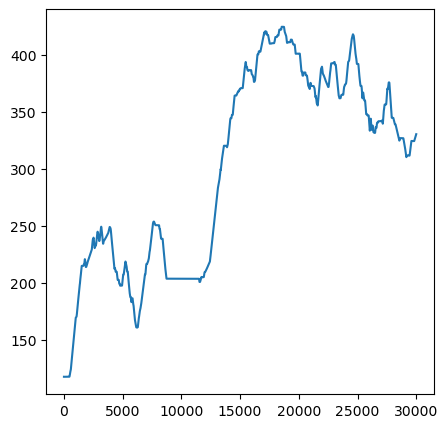

In [4]:
plt.figure(figsize=(5, 5))
plt.plot(player_coords[:,0])
plt.show()

In [6]:
def draw_cross(draw: ImageDraw.Draw, coord: tuple[int, int], time: int):
    offset = 10
    topleft = (coord[0] - offset, coord[1] - offset)
    topright = (coord[0] + offset, coord[1] - offset)
    bottomleft = (coord[0] - offset, coord[1] + offset)
    bottomright = (coord[0] + offset, coord[1] + offset)
    draw.line(topleft + bottomright, fill=(0, 0, 255), width=4)
    draw.line(topright + bottomleft, fill=(0, 0, 255), width=4)
    font = ImageFont.load_default(size=20)
    draw.text((coord[0] + 30, coord[1]), anchor="mm", fill="blue",
                  text=f"{time}mn", font=font, align="center")


with Image.new(mode="RGB", size=(max_coord_x, max_coord_z)) as im:
    draw = ImageDraw.Draw(im)
    for m in mushrooms_coords:
        draw.ellipse((tuple((m - 10).astype(int)), tuple((m + 10).astype(int))))
    draw.line([tuple(p) for p in player_coords.astype(int)], fill=(255, 0, 0), width=5)
    for i, p in enumerate(player_coords):
        if i % (50 * 60) == 0:
            draw_cross(draw, p.astype(int), i // (50 * 60))
    display.display(im)

TypeError: load_default() got an unexpected keyword argument 'size'

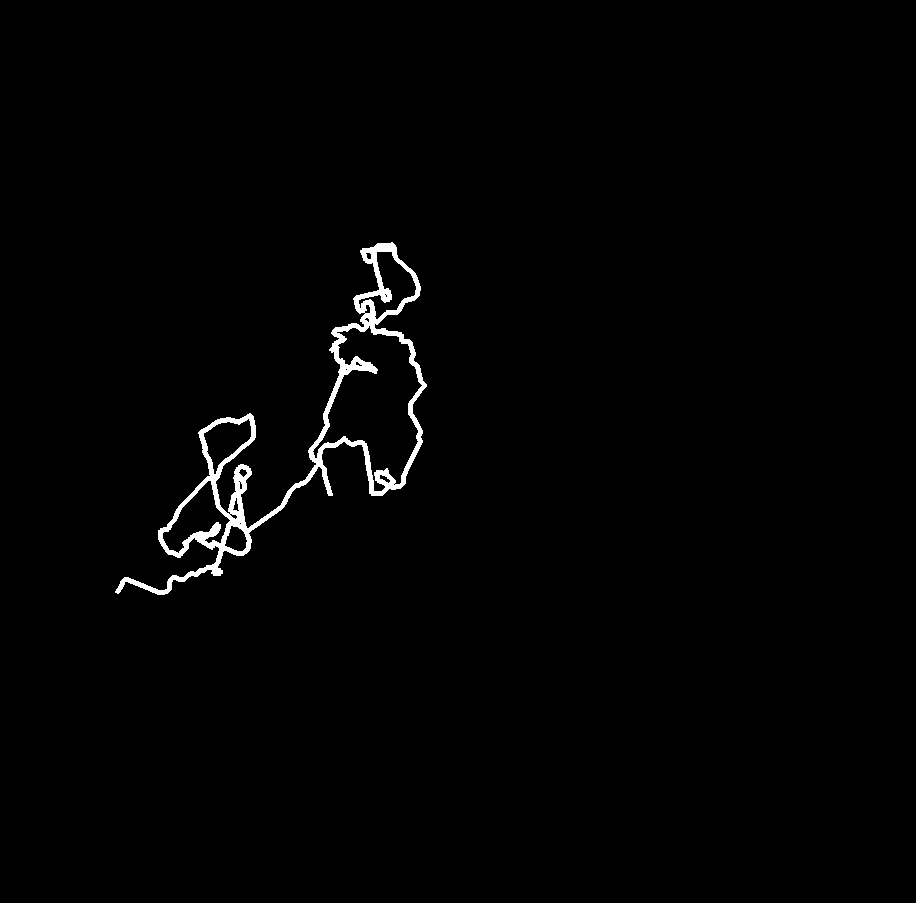

In [7]:
with Image.new(mode="1", size=(max_coord_x, max_coord_z)) as im:
    draw = ImageDraw.Draw(im)
    draw.line([tuple(p) for p in player_coords.astype(int)], fill=1, width=5)
    display.display(im)
    player_trajectory = np.array(im)

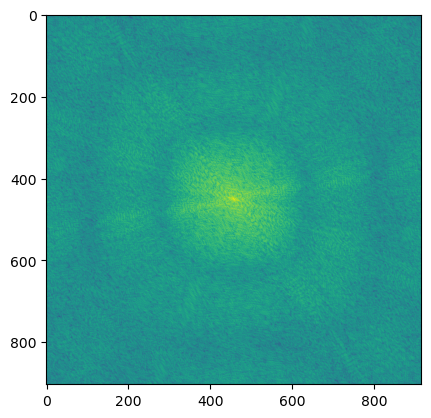

In [8]:
fft_transform = np.fft.fftshift(np.fft.fft2(player_trajectory))
fft_transform = np.log(abs(fft_transform))
# with Image.fromarray(fft_transform.astype(np.int8), mode="L") as im:
#     display.display(im)
plt.imshow(fft_transform)
